# 2022 K리그1 선수 기록 데이터

- 본 데이터프레임은 총 429명 (중복 포함)의 선수 데이터와 77개의 선수 기록 및 신상 정보를 담고 있다.
- 출처는 K리그 데이터포털의 2022년 경기 기록을 기반으로 구단 홈페이지, 나무위키 등을 활용해 포지션, 출생연도, 신장 등의 정보를 별도로 추출하였다. 
- 범주형 변수: 팀, 선수명, 포지션, 국적, 신장, 출생연도
- 연속형 변수: 출전시간, 득점, 도움, 슈팅, 유효슈팅 등 총 71개 변수

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

In [2]:
url = "C:/박규영/2022K리그포트폴리오/K리그1.xlsx"
df = pd.read_excel(url)
df

,팀,선수명,포지션,국적,신장,출전시간,득점,도움,슈팅,유효슈팅,...,차단,획득,블락,볼미스,파울,피파울,경고,퇴장,번호,출생연도
0,강원,갈레고,FW,브라질,172,386,3,0,11,5,...,6,24,8,4,11,10,2,0,11,1997
1,인천,강민수,CB,대한민국,186,2029,0,0,1,1,...,36,68,63,4,10,16,1,1,4,1986
2,포항,강상우,FB,대한민국,176,49,0,0,0,0,...,0,2,0,0,0,0,0,0,10,1993
3,전북,강상윤,MF,대한민국,170,551,0,0,8,3,...,13,20,13,7,12,5,3,0,36,2004
4,서울,강상희,CB,대한민국,180,239,0,0,0,0,...,4,6,4,0,0,1,0,0,28,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,김천,황인재,GK,대한민국,187,1517,0,0,0,0,...,0,28,2,0,1,4,2,0,1,1994
425,대구,황재원,FB,대한민국,180,2906,1,3,14,3,...,68,180,68,18,42,26,5,0,2,2002
426,울산,황재환,MF,대한민국,170,275,0,0,4,2,...,3,14,5,2,4,1,0,0,14,2001
427,서울,황현수,CB,대한민국,183,486,0,0,1,0,...,7,15,18,1,3,1,1,0,2,1995


## EDA


### 1. 중복 선수 확인
- 앞서 언급한 것처럼 본 데이터프레임은 중복된 선수를 포함하고 있다. 따라서 중복 선수에 대한 확인이 필요하다. 
    - 동명이인 구분 
    - 한 시즌 내에 팀을 2번 이상 옮긴 선수 구분

In [3]:
# 중복 선수의 숫자 확인

df2 = df[df.duplicated(subset=['선수명'], keep=False)]
col = ['선수명','팀','출생연도']
df3 = df2[col]

print('중복 선수 숫자:', len(df3.reset_index(drop=True)))

중복 선수 숫자: 46


In [5]:
df2 = df2.groupby('선수명').size().reset_index(name='중복 개수')

print(df2.sort_values(by='중복 개수', ascending=False).reset_index(drop=True))

      선수명  중복 개수
0     박상혁      3
1     이지훈      3
2     김민석      2
3     이준석      2
4     하창래      2
5   팔라시오스      2
6     조규성      2
7     정현철      2
8     정승현      2
9    일류첸코      2
10    이태희      2
11    이종성      2
12    김민혁      2
13     이용      2
14    유인수      2
15    연제운      2
16    서진수      2
17    명준재      2
18    김태환      2
19    김주성      2
20    김승대      2
21    한승규      2


#### 박상혁, 이지훈은 중복이 3개, 나머지 선수들은 2개임
- (1) 박상혁, 이지훈 케이스
- (2-1) 2개로 집계된 선수중 시즌 중반 이적한 케이스
- (2-2) 2개로 집계된 선수중 동명이인 케이스

#### (1) 박상혁과 이지훈 케이스

In [117]:
df3[(df3['선수명'] == '박상혁') | (df3['선수명'] == '이지훈')]

,선수명,팀,출생연도
161,박상혁,강원,2002
162,박상혁,김천,1998
163,박상혁,수원삼성,1998
307,이지훈,성남,1994
308,이지훈,전북,2002
309,이지훈,김천,2002


- 1998년생 박상혁이 2명, 2002년생 박상혁이 1명임
- 이는 1998년생 박상혁이 시즌 중반에 한 번 이적을 했고, 별도로 2002년생 박상혁이 존재한다는 것임
- 이지훈 역시 마찬가지로 해석가능함
- 박상혁과 이지훈은 동명이인 + 시즌중반에 한 번 이적을 한 경우임

#### (2) 2개로 집계된 선수중 시즌 중반 이적한 케이스

In [118]:
df4 = df3[(df3['선수명'] != '박상혁') & (df3['선수명'] != '이지훈')] # 박상혁 이지훈 제외
df_trans = df4[df4.duplicated(subset=['선수명', '출생연도'], keep=False)]
df_trans = df_trans.drop_duplicates(subset=['선수명'])

print('시즌 중반에 이적한 케이스 수:',len(df_trans))
print('--------------------------')
print(df_trans['선수명'])

시즌 중반에 이적한 케이스 수: 17
--------------------------
65       김민혁
75       김승대
91       김주성
136      명준재
194      서진수
233      연제운
249      유인수
286       이용
298      이종성
303      이준석
320     일류첸코
343      정승현
355      정현철
360      조규성
396    팔라시오스
400      하창래
406      한승규
Name: 선수명, dtype: object


- 총 17명의 선수가 시즌 중반에 이적하였고, 그 명단은 위와 같음

#### (2-2) 2개로 집계된 선수중 동명이인 케이스

In [120]:
result = pd.DataFrame(columns=df3.columns)

for idx, row in df4.iterrows(): #iterrows루프를 이용해 인덱스와 행 추출
    player_name = row['선수명']
    birth_year = row['출생연도']
    matching_rows = df_trans[(df_trans['선수명'] == player_name) & (df_trans['출생연도'] == birth_year)]

    if matching_rows.empty: # 생성한 matching_rows가 비었다면 df5의 행을 추가함
        result = result.append(row, ignore_index=True)

C:\Users\koaro\AppData\Local\Temp\ipykernel_9068\1607042549.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(row, ignore_index=True)
C:\Users\koaro\AppData\Local\Temp\ipykernel_9068\1607042549.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(row, ignore_index=True)
C:\Users\koaro\AppData\Local\Temp\ipykernel_9068\1607042549.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(row, ignore_index=True)
C:\Users\koaro\AppData\Local\Temp\ipykernel_9068\1607042549.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(row, ignore_index=True)
C:\Users

In [121]:
print(result)

   선수명     팀  출생연도
0  김민석    김천  1997
1  김민석    인천  2002
2  김태환  수원삼성  2000
3  김태환    울산  1989
4  이태희    인천  1995
5  이태희    대구  1992


- 총 6명의 선수가 동명이인임

#### 중복선수 요약
- 총 19명의 선수가 시즌 중반에 이적함
- 총 10명의 선수가 동명이인이며 명단은 다음과 같음
- 김민석(1997), 김민석(2002), 김태환(2000), 김태환(1989), 박상혁(2002), 박상혁(1998), 이지훈(2002), 이지훈(1994), 이태희(1995), 이태희(1992) 
- 총 410명(중복제외)의 선수 데이터가 포함되어있음 

### 2.  U-22 선수 출전시간 EDA
- ANOVA에 사용하 변수 추정하기
- 구단별 U-22 선수 출전시간 간략히 확인
- 포지션별U-22 선수 출전시간 간략히 확인

#### 중복선수 제거가 필요없는 경우, 팀 단위로 차이 유무 확인할 때 (특정 팀에서 뛴 시간 고려 필요) (data1)
#### 중복선수 제거가 필요한 경우, 팀이 아닌 리그 전체 혹은 나이 단위로 차이 유무 확인할 때 (data2)

In [6]:
df['나이'] =  2022 - df['출생연도']
col_name = ['선수명','팀','포지션','나이','출전시간','국적']

data1 = df[col_name]
data1 = data1[data1['국적'] == '대한민국']
data1['U22여부'] = data1['나이'].apply(lambda x: '오버' if x >= 23 else '언더')

In [7]:
# 중복선수 제거작업

result = data1.groupby(['선수명', '나이'], as_index=False).agg({'출전시간': 'sum'}) # result에 중복선수 출전시간 합계 저장
data2 = data1.drop(columns=['출전시간']) 
data2 = pd.merge(data2, result, left_on=['선수명', '나이'], right_on=['선수명', '나이'], how='left')
data2 = data2.drop_duplicates(subset=['선수명', '나이', '출전시간'])

In [8]:
# 중복제거 여부 확인 

data2[data2['선수명']=='이지훈']

,선수명,팀,포지션,나이,국적,U22여부,출전시간
277,이지훈,성남,FB,28,대한민국,오버,874
278,이지훈,전북,FW,20,대한민국,언더,335


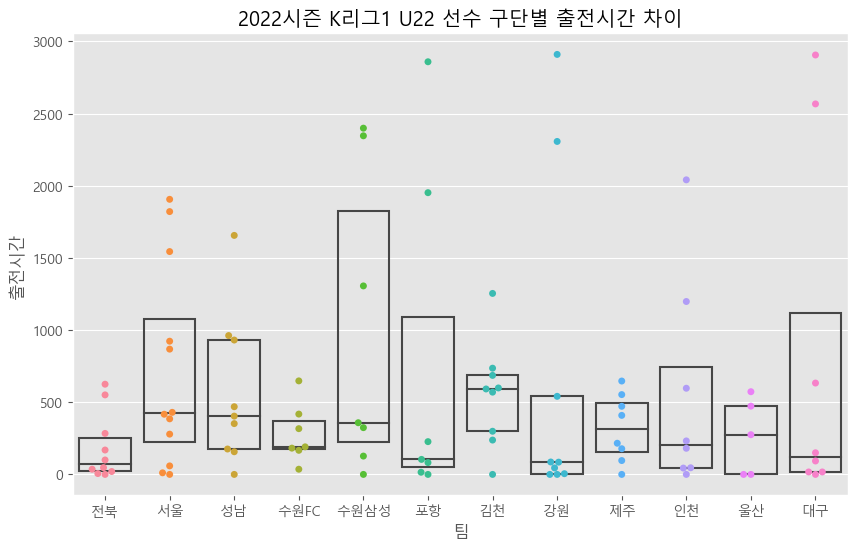

In [210]:
plt.figure(figsize=(10,6))
plt.title('2022시즌 K리그1 U22 선수 구단별 출전시간 차이')

# plot swarmplot
sns.swarmplot(data=data1[data1['U22여부'] == '언더'], x="팀", y="출전시간")

# plot boxplot
sns.boxplot(data=data1[data1['U22여부'] == '언더'], x="팀", y="출전시간", 
            showcaps=False,             # 박스 상단 가로라인 보이지 않기
            whiskerprops={'linewidth':0}, # 박스 상단 세로 라인 보이지 않기 
            showfliers=False,           # 박스 범위 벗어난 아웃라이어 표시하지 않기
            boxprops={'facecolor':'None'}, # 박스 색상 지우기
        )
plt.show();

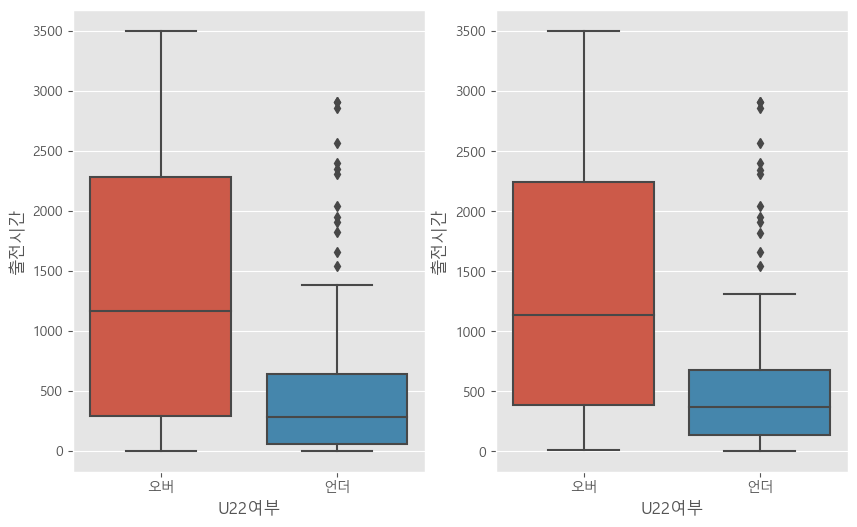

In [220]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.boxplot(data=data2, x='U22여부',y='출전시간')

plt.subplot(1,2,2)
sns.boxplot(data=data1[data1['출전시간'] != 0], x='U22여부',y='출전시간')

plt.show();

In [38]:
len(a[a['출전시간']==0])

13

In [37]:
a = data2[data2['U22여부']=='언더'].sort_values(by='출전시간', ascending=False)
not_zero = a[a['출전시간'] != 0]
not_zero.describe()

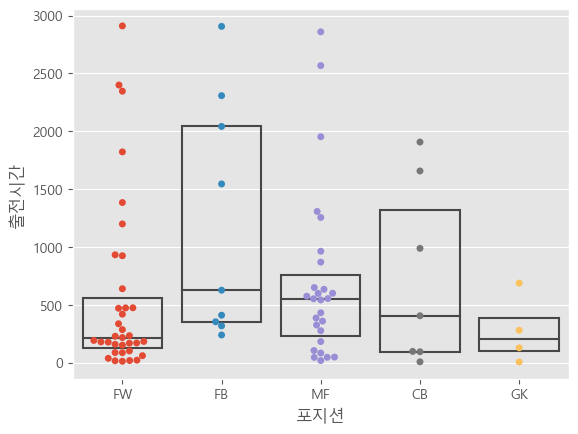

In [77]:
sns.swarmplot(data=not_zero, x="포지션", y="출전시간")
sns.boxplot(data=not_zero, x="포지션", y="출전시간", 
            showcaps=False,             # 박스 상단 가로라인 보이지 않기
            whiskerprops={'linewidth':0}, # 박스 상단 세로 라인 보이지 않기 
            showfliers=False,           # 박스 범위 벗어난 아웃라이어 표시하지 않기
            boxprops={'facecolor':'None'}, # 박스 색상 지우기
        )
plt.show();

In [67]:
position = ['FW','FB','MF','CB','GK']

for i in range(len(position)):
    cnt = len(not_zero[not_zero['포지션'] == position[i]])
    print(f'U22 {position[i]} 숫자:', cnt,'명')

U22 FW 숫자: 35 명
U22 FB 숫자: 9 명
U22 MF 숫자: 27 명
U22 CB 숫자: 7 명
U22 GK 숫자: 4 명
